In [168]:
import xarray as xr
import netCDF4 
import numpy as np
import os 
import glob
import pyart
from pyart.config import get_metadata
import matplotlib.pyplot as plt
import matplotlib.dates as md
import warnings
import re

#filling data so that it has dimensions of max_az by max_gate
def fill_data(data):
    fill_az = max_az-data.shape[0]
    fill_gate = max_gate-data.shape[1]
    
    #filling gates
    fill_arr= np.full((data.shape[0], fill_gate), np.nan)
    data = np.ma.concatenate((data, fill_arr), axis=1)
    
    #filling azimuths
    fill_arr = np.full((fill_az, data.shape[1]), np.nan)
    data = np.ma.concatenate((data, fill_arr), axis=0)
    data = np.ma.array(data, mask=np.isnan(data))
    return data 

def numtodate(numtime):
    return np.datetime64('1970-01-01')+np.timedelta64(numtime, 's')
def datetonum(date):
    return np.timedelta64(date-np.datetime64('1970-01-01'), 's').astype('int')

#angle in degrees
def rangetoheight(r, angle):
    return r*np.sin(angle*np.pi/180)

#from Portland State Aerospace Society, Version 1.03, 12/22/2004.pressure in hPa
def pressuretoalt(pressure):
    return 44331.5 - 4946.62 * (pressure*100) ** (0.190263)

def find_nearest(arr, data):
    return np.argmin(abs(arr-data))


warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Choose Event

In [169]:
event = 'Albany'

temp_file = f'{event}temp.nc'

# Gather Files

In [170]:
if event =='Albany':
    directory = os.path.join('/Volumes/A/', f'RaXPol-IMPACTS-20220225') #getting directory containing subdirectories for data at each time step
    data_dirs = [x for x in os.walk(directory)][3:] #retrieving the data subdirectories 

else:
    directory = os.path.join('/Volumes/P/', f'RaXPol-IMPACTS-20220129')
    data_dirs = [x for x in os.walk(directory)][3:]

if len(data_dirs) ==0:
    raise Exception('Insert Flash Drive')

# Gather Data

In [171]:
var_keys = ['Intensity','Differential_Reflectivity', 'PhiDP', 'RhoHV']
var_names = ['reflectivity', 'differential_reflectivity', 'differential_phase', 'cross_correlation_ratio']

radar_data = {} 

for key in var_keys:
    radar_data[key] = []
    radar_data[key] = []

radar_data['time'] = []
radar_data['fixed_angle'] = []
radar_data['altitude'] = []
radar_data['azimuth'] = []

max_gate = 2493
if event =='Albany':
    max_az = 360
else:
    max_az = 455


num_sweeps = 0
for timestep in range(len(data_dirs)):

    data_dir = data_dirs[timestep] 
    var_files = [os.path.join(data_dir[0],file) for file in data_dir[2]] 

    ref_dataset = xr.load_dataset(var_files[np.where([file is not None for file in np.array([re.search('-Z.nc', file) for file in var_files])])[0][0]])
    if ref_dataset.attrs['ScanType']!='PPI':
        continue

    zdr_dataset = xr.load_dataset(var_files[np.where([file is not None for file in np.array([re.search('-D.nc', file) for file in var_files])])[0][0]])
    phidp_dataset = xr.load_dataset(var_files[np.where([file is not None for file in np.array([re.search('-P.nc', file) for file in var_files])])[0][0]])
    rhohv_dataset = xr.load_dataset(var_files[np.where([file is not None for file in np.array([re.search('-R.nc', file) for file in var_files])])[0][0]])
    
    fixed_angle = ref_dataset.attrs['Elevation']


    if fixed_angle!=14:
        continue
        
    if event =='Plymouth':
        if numtodate(ref_dataset.attrs['Time'])>np.datetime64('2022-01-29T18:30'):
            break
            
    radar_data['fixed_angle'].append(zdr_dataset.attrs['Elevation'])
    radar_data['time'].append(zdr_dataset.attrs['Time'])
    radar_data['altitude'].append(zdr_dataset.attrs['Height'])
    radar_data['azimuth'].append(zdr_dataset['Azimuth'].data)

    var_idx=0
    for dataset in [ref_dataset, zdr_dataset, phidp_dataset, rhohv_dataset]:
        var_key = var_keys[var_idx]
        data = dataset[var_key].data
    
   
        data = np.ma.array(data, mask = (data== dataset.attrs['MissingData']) \
                          | (data ==dataset.attrs['RangeFolded']))
        
        data = fill_data(data)
        
        if dataset is phidp_dataset:

            data=data*180/np.pi

        radar_data[var_key].append(data)

        var_idx+=1

    cc_mask = radar_data[var_key][-1]>1.1
    for var_key in var_keys:
        radar_data[var_key][-1] = np.ma.array(radar_data[var_key][-1], mask=cc_mask)
    
    num_sweeps+=1

In [172]:
#Creating a pyart Radar object that contains data for every scan for the event. 
radar = pyart.testing.make_empty_ppi_radar(max_gate, max_az, num_sweeps)
radar.range['data']= np.arange(30, max_gate*30+1, 30)
#radar.range['units'] = 'kilometers'
radar.fixed_angle['data'] = np.array(radar_data['fixed_angle'])
radar.altitude['data'] =   np.array(radar_data['altitude'])
radar.azimuth['data'] = np.array(np.array(radar_data['azimuth']).flatten())
radar.scan_type = 'ppi'
radar.time['data'] = np.sort(radar_data['time'])
radar.latitude['data'] = ref_dataset.attrs['Latitude']
radar.longitude['data'] = ref_dataset.attrs['Longitude']

var_idx = 0
radar.fields = {}
for var_name in var_names:
    var_key = var_keys[var_idx]
    radar.fields[var_name] = get_metadata(var_name)
    data = np.ma.array(radar_data[var_key])
    data = data[np.argsort(radar_data['time'])]

    radar.fields[var_name]['data'] = data.reshape(-1,data.shape[-1])
    var_idx+=1

    
#removing bias in ZDR for Albany event, or bias in rhohv for Plymouth event 

if event =='Albany':
    error_fields = ['differential_reflectivity']
else:
    error_fields = ['cross_correlation_ratio']
    
for error_field in error_fields:
    max_diff = 0
    max_diff_arr = np.zeros((max_az, max_gate))
    for sweepnum in range(radar.nsweeps):
        if sweepnum<radar.nsweeps-1:
            s_idx = sweepnum*max_az
            e_idx = s_idx+max_az
            s_idx2 = e_idx
            e_idx2 = s_idx2+max_az
        else:
            break
        data = radar.fields[error_field]['data'][s_idx:e_idx]
        data2 = radar.fields[error_field]['data'][s_idx2:e_idx2]

        if event=='Albany':
            diff = abs(data2-data).mean()
            diff_arr = abs(data2-data)
        else:
            diff = (data2-data).mean()
            diff_arr = data2-data
        if diff>max_diff:
            max_diff = diff
            max_diff_arr = diff_arr
            max_diff_loc = sweepnum


    for sweepnum in range(max_diff_loc+1):

        if event=='Plymouth':
            if sweepnum!=max_diff_loc:
                continue

        s_idx = sweepnum*max_az
        e_idx = s_idx+max_az

        radar.fields[error_field]['data'][s_idx:e_idx]+= max_diff_arr


for field in radar.fields:
    radar.fields[field]['data'] = radar.fields[field]['data'].T
    
radar.fields['specific_differential_phase']  = pyart.retrieve.kdp_vulpiani(radar, band ='X', prefilter_psidp=True)[0]
radar.fields['specific_differential_phase']['units'] = r'°km$^{-1}$'  

for field in radar.fields:
    radar.fields[field]['data'] = radar.fields[field]['data'].T


/var/folders/31/s39c2x6d037_7hyqq4dw3tnh0000gn/T/ipykernel_25279/2516800021.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  radar.azimuth['data'] = np.array(np.array(radar_data['azimuth']).flatten())


# Retrieving ERA5 Temperature Data

In [173]:
# import cdsapi

# c = cdsapi.Client()

# if event== 'Albany':
#     time_retrieval = ['09:00', '10:00', '11:00','12:00', '13:00', '14:00','15:00', '16:00']
#     month = '02'
#     day = '25'
# else:
#     time_retrieval = ['14:00','15:00', '16:00', '17:00', '18:00', '19:00']
#     month = '01'
#     day = '29'

# c.retrieve(
#     'reanalysis-era5-pressure-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': 'temperature',
#         'pressure_level': [
#             '1', '2', '3',
#             '5', '7', '10',
#             '20', '30', '50',
#             '70', '100', '125',
#             '150', '175', '200',
#             '225', '250', '300',
#             '350', '400', '450',
#             '500', '550', '600',
#             '650', '700', '750',
#             '775', '800', '825',
#             '850', '875', '900',
#             '925', '950', '975',
#             '1000',
#         ],
#         'year': '2022',
#         'month': f'{month}',
#         'day': f'{day}',
#         'time': time_retrieval,
#     },
#     f'{temp_file}')

# Creating QVP Time series


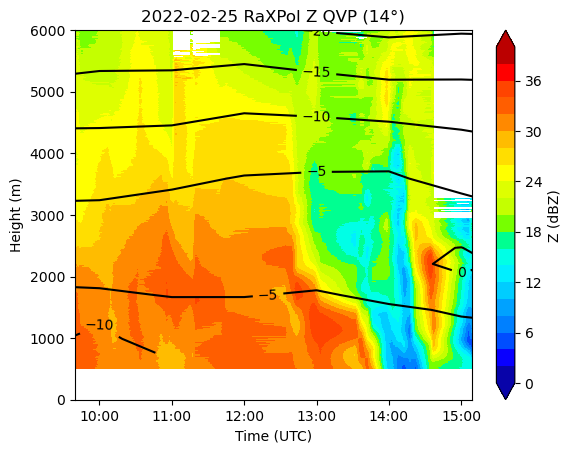

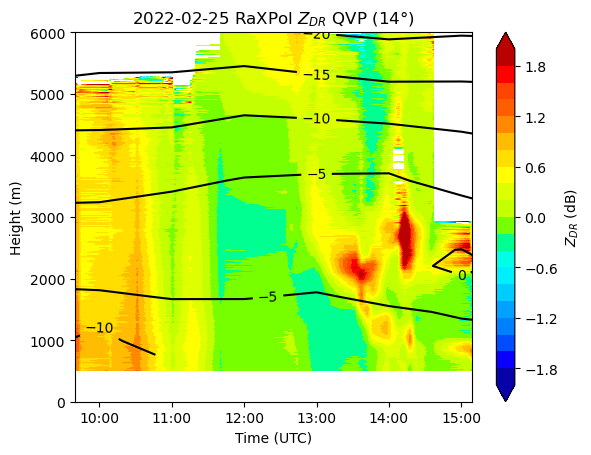

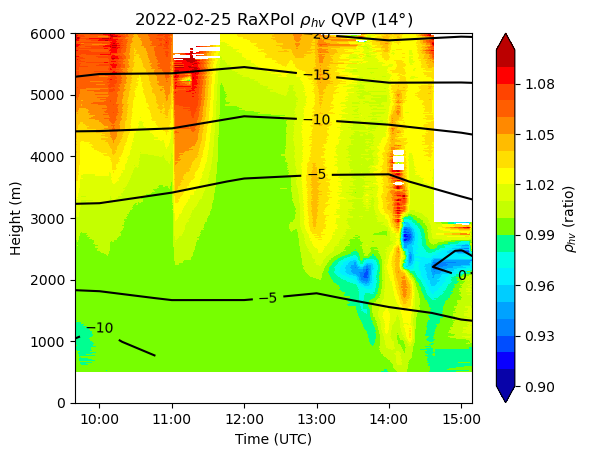

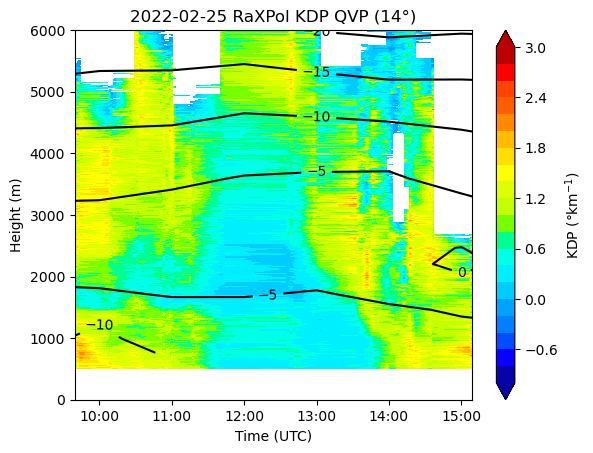

In [174]:
colors = ['#0803A9','#0900FF', '#004DFF','#0080FF', '#00A2FF', '#00CDFF',\
          '#00EFFF','#00FFE6','#00FF91','#77FF00','#C4FF00','#DEFF00','#FFFF00','#FFDE00',\
          '#FFBC00','#FF8900','#FF5E00','#FF4400','#FF0000','#BB0000']
field_names = ['Z','$Z_{DR}$', r'$\rho_{hv}$', 'KDP']
fields = ['reflectivity', 'differential_reflectivity', 'cross_correlation_ratio', 'specific_differential_phase']

ranges = ((0,40),(-2, 2),(0.9, 1.1), (-1,3))
times = np.array([numtodate(t) for t in radar.time['data']])
date  = str(times[0]).split('T')[0]
height = rangetoheight(radar.range['data'], radar.fixed_angle['data'][0]) + radar.altitude['data'][0]
height_start = find_nearest(height, 500)
height = height[height_start:]


era5 = xr.load_dataset(f'{temp_file}')
era5['level'] = pressuretoalt(era5['level'])

temp = (era5['t'][:,find_nearest(era5['level'].data, height[-1]):,\
                   find_nearest(era5['latitude'].data, radar.latitude['data']), \
                   find_nearest(era5['longitude'].data-360,radar.longitude['data'])]-273).T
level_start = find_nearest(temp['level'].data, 500)
t_levels = temp['level'].data[:level_start]
temp = temp[:level_start,:]

field_idx = 0
QVPs = []
for field in fields:
    
    fig, axis = plt.subplots()

    QVP = np.ma.array([radar.get_field(sweepnum, field).mean(0) for sweepnum in range(radar.nsweeps)]).T
    QVPs.append(QVP)
    
    cs = axis.contourf(times, height, QVP[height_start:, ], levels = np.linspace(ranges[field_idx][0], ranges[field_idx][1], 21),\
                      colors = colors, extend='both')
    cbar = fig.colorbar(cs)
    try:
        cbar.ax.set_ylabel(field_names[field_idx] + f" ({radar.fields[field]['units']})")
    except:
        cbar.ax.set_ylabel(field_names[field_idx])


    cbar.ax.set_yticks([np.round(tick, 2) for tick in cbar.ax.get_yticks()])
    
    cs2 = axis.contour(temp['time'].data, t_levels, temp, levels = \
                       np.arange(-20, 5, 5), colors=['#000000']*len(era5['level']))
    axis.clabel(cs2, cs2.levels, inline=True, fontsize=10)

    axis.set_ylim([0,6000])
    axis.set_ylabel('Height (m)')
    axis.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
    axis.set_xlabel('Time (UTC)')
    axis.set_title(f'{date} RaXPol ' + field_names[field_idx] + ' QVP (14°)')
    
    plt.savefig(f'Figures/{event}/series/QVP/{field}.png')
    plt.show()

    
    field_idx+=1


# Creating Fixed-Time QVPs

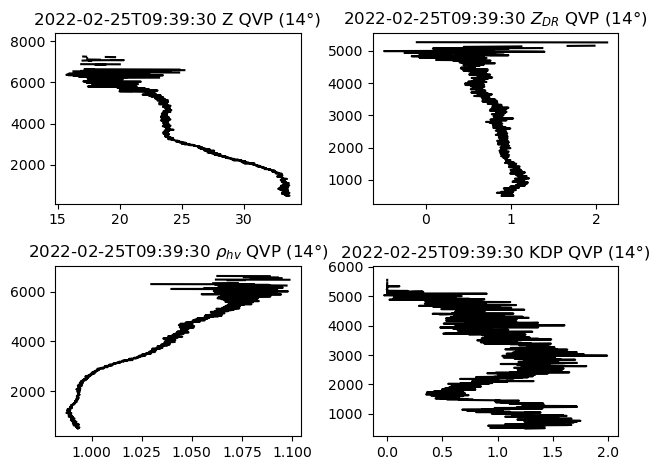

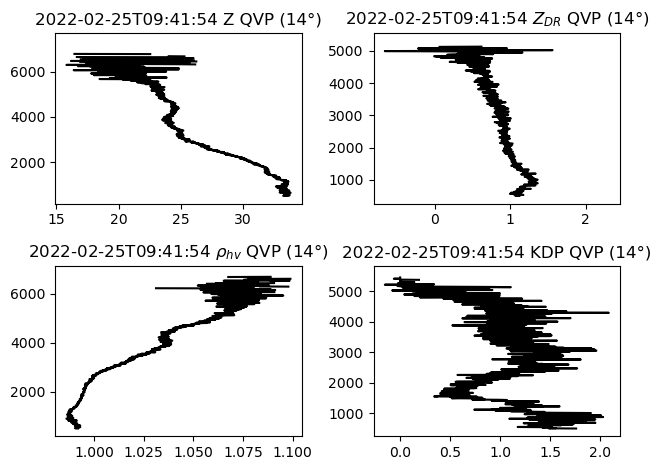

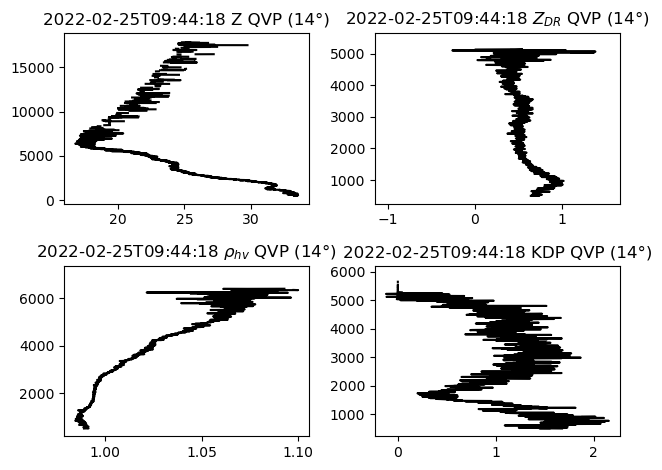

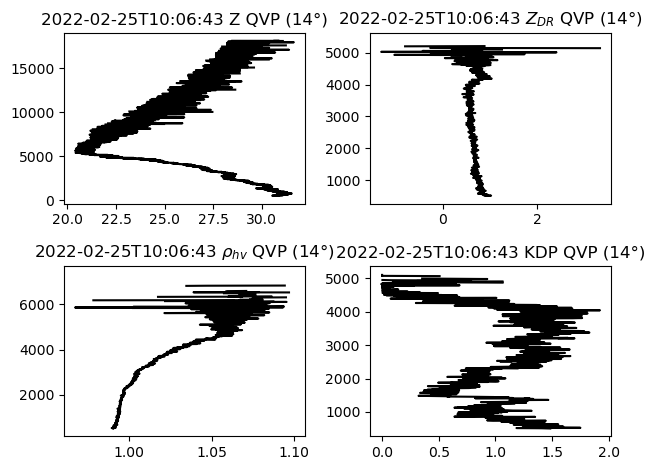

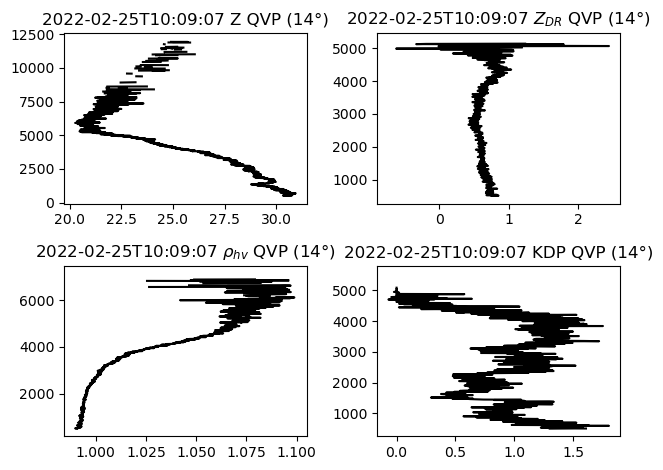

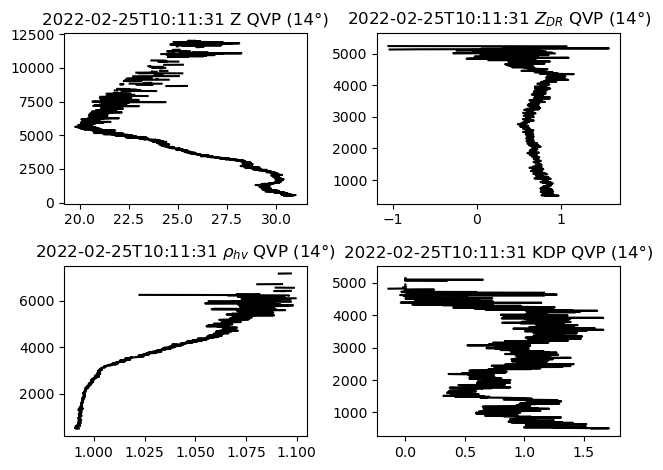

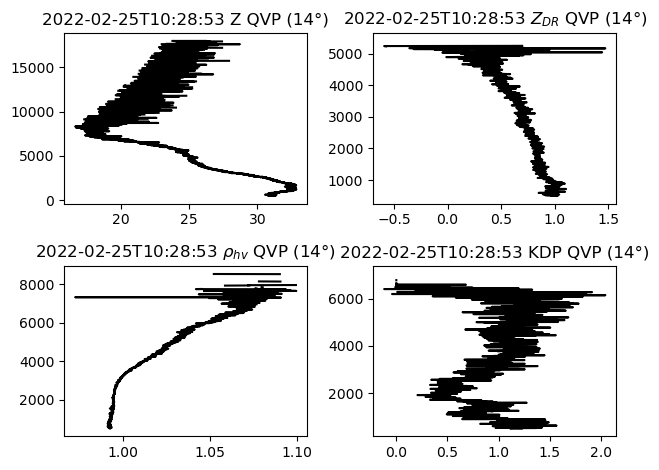

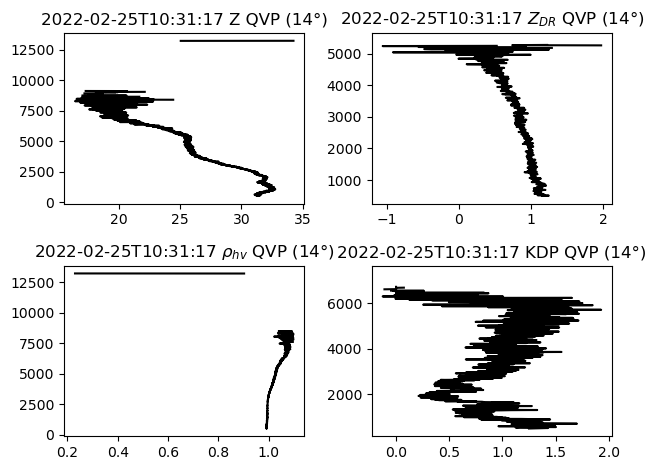

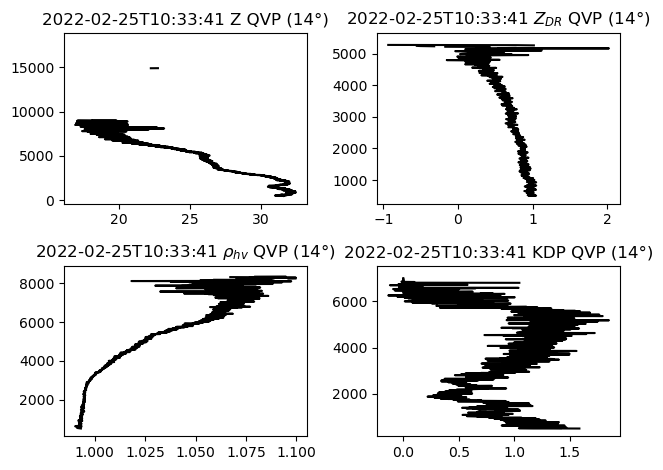

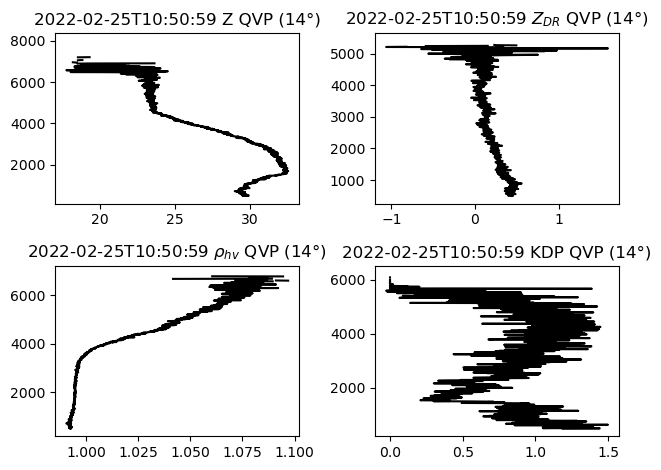

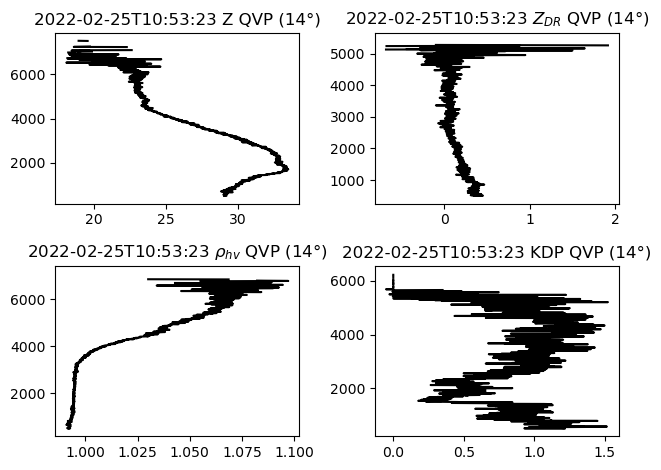

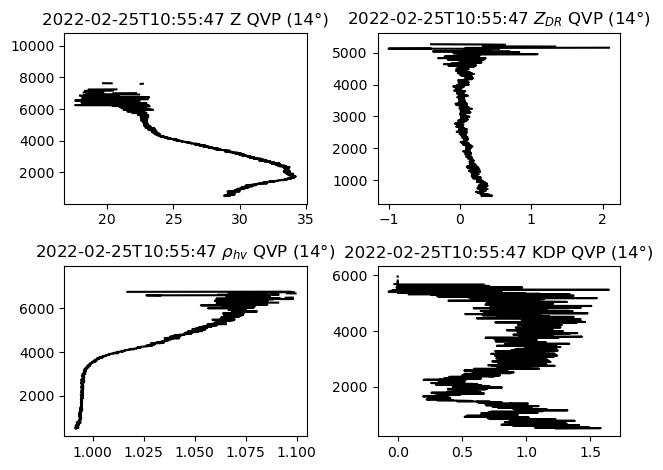

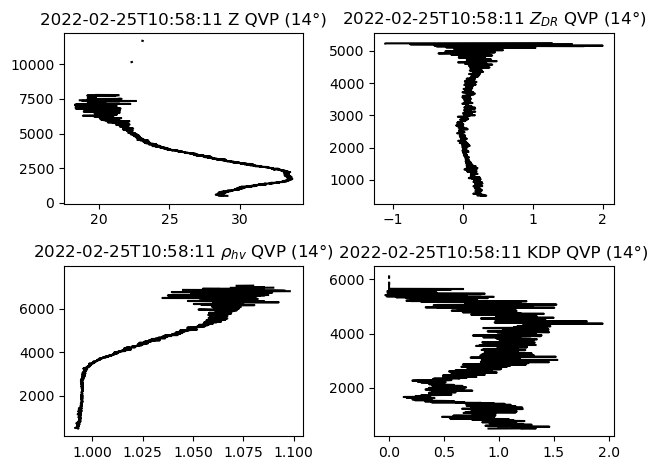

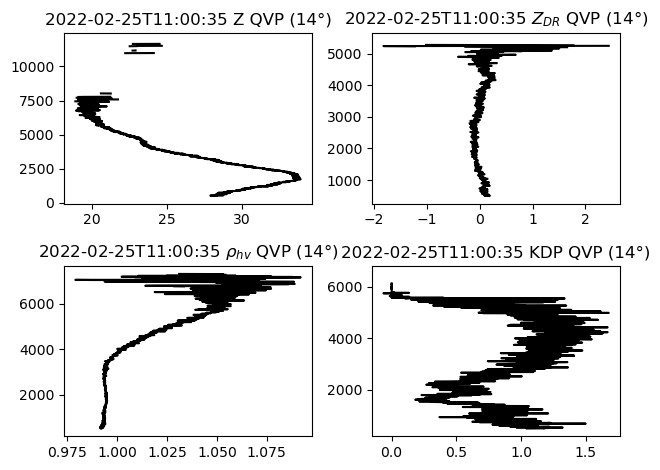

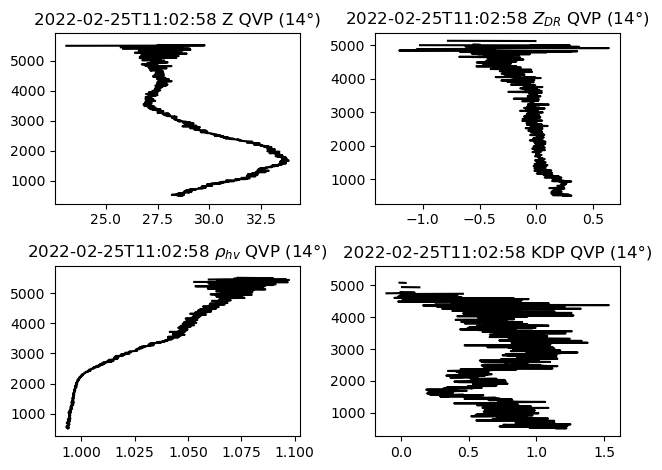

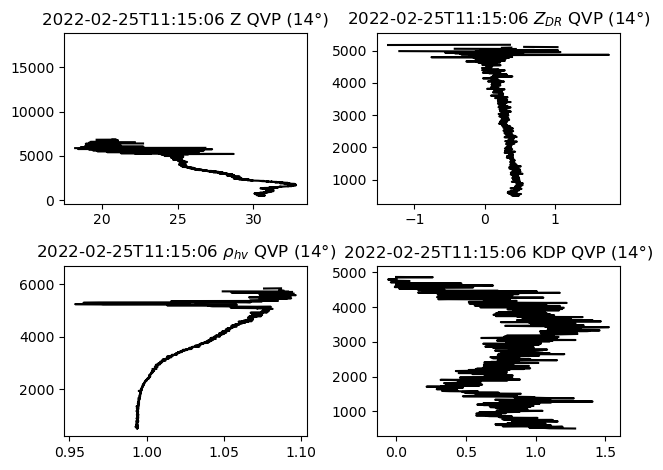

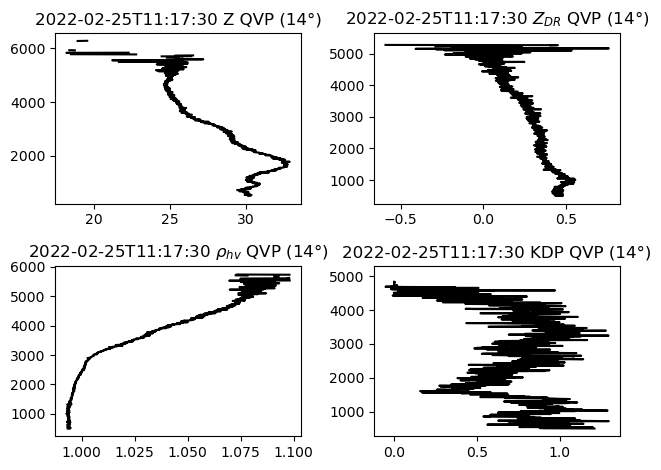

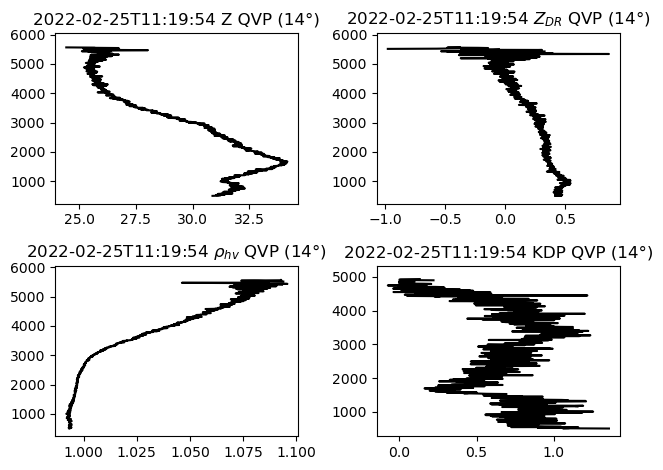

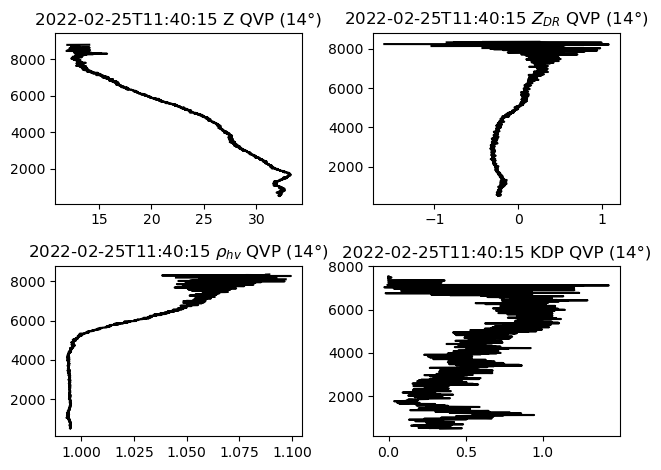

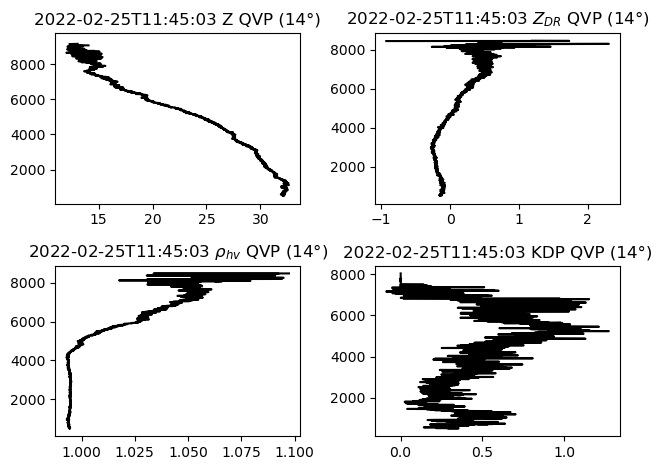

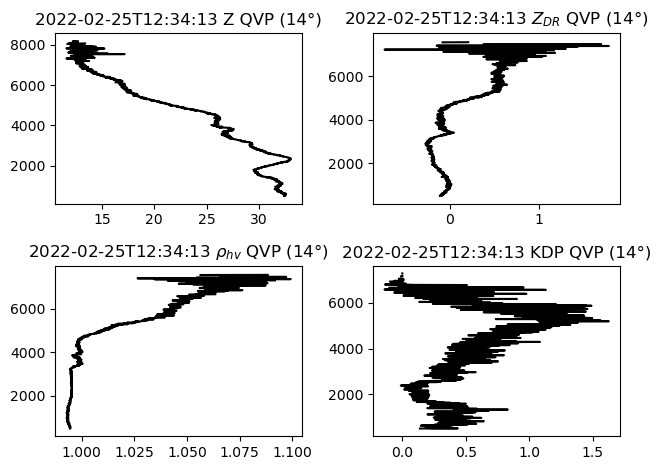

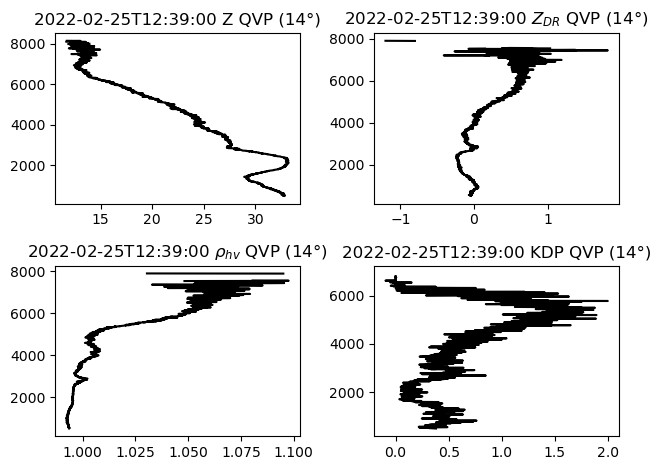

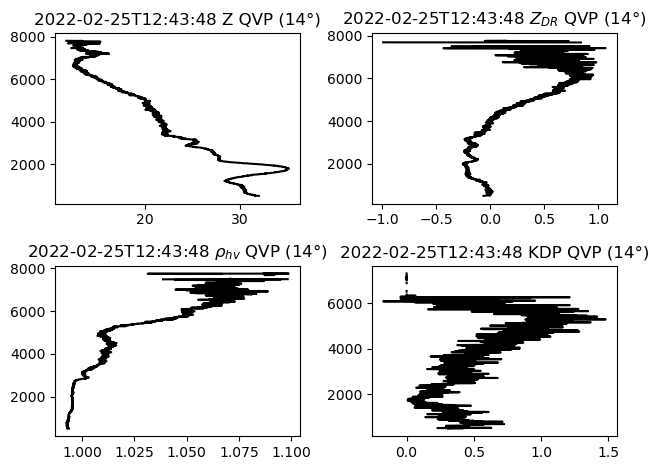

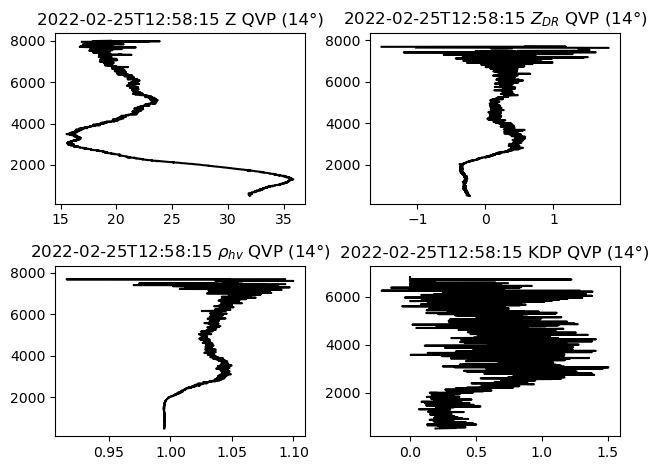

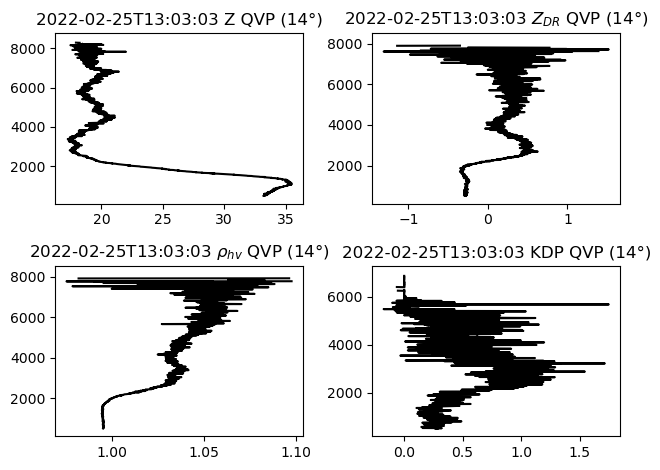

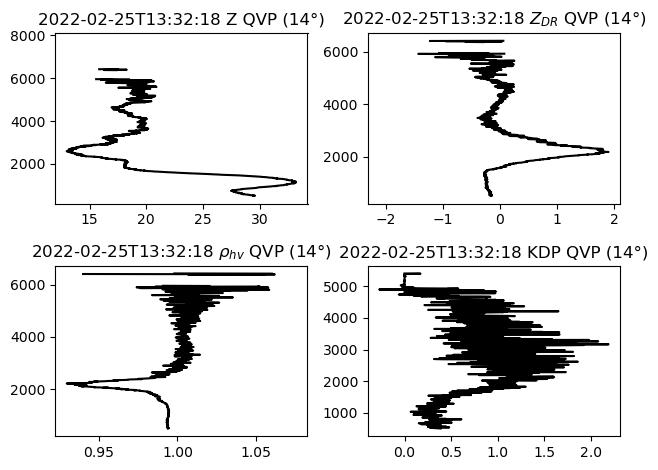

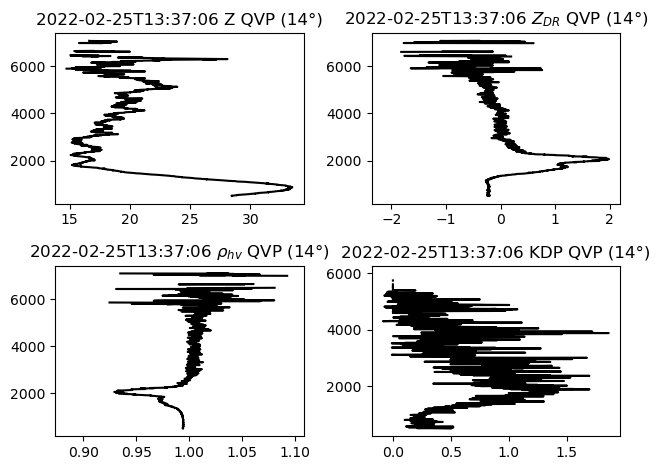

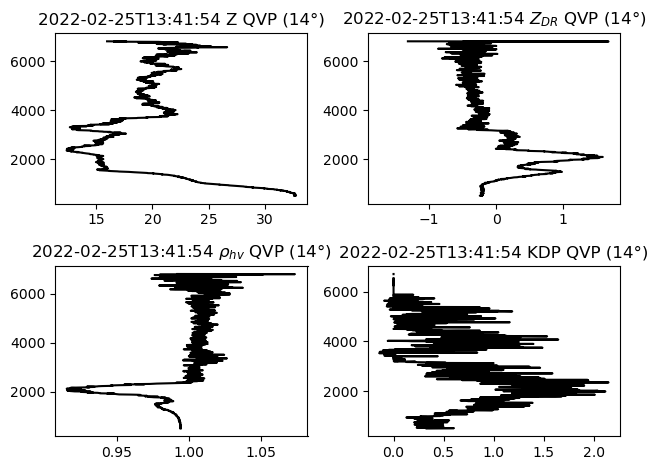

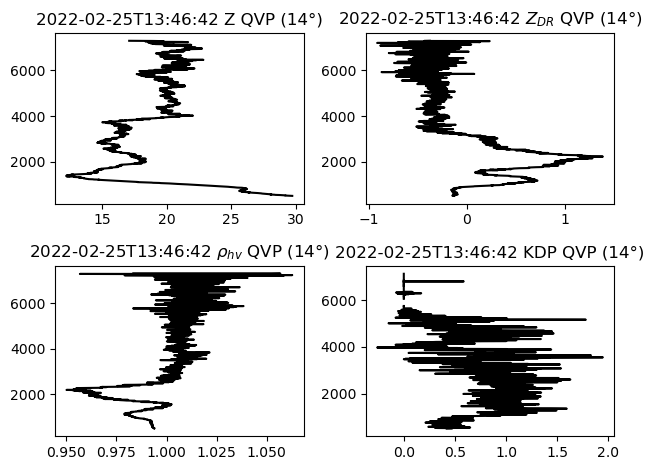

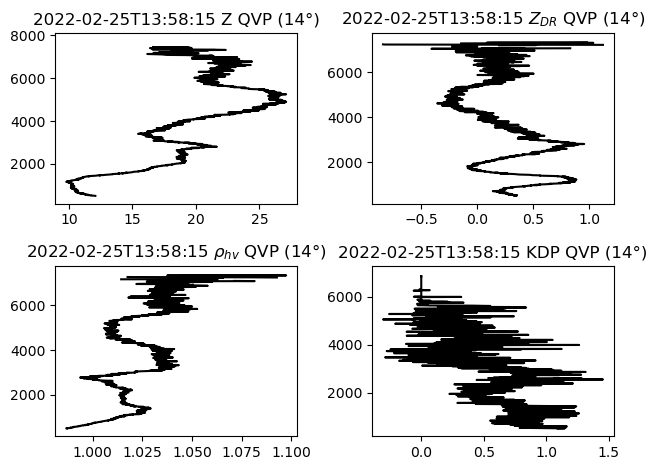

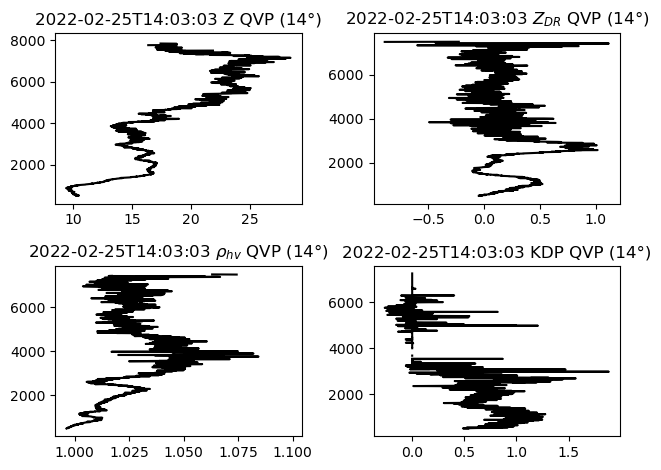

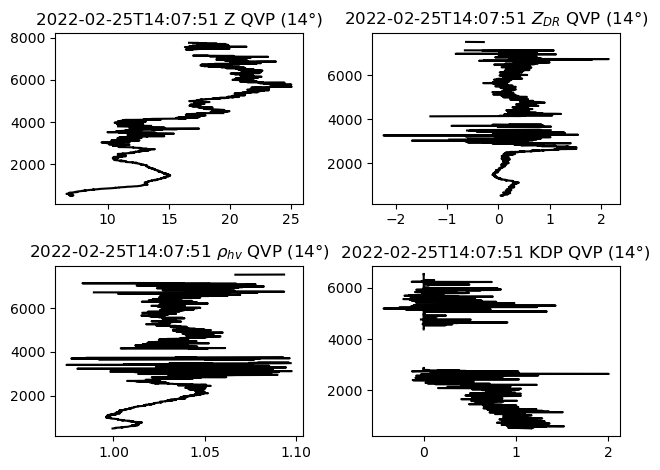

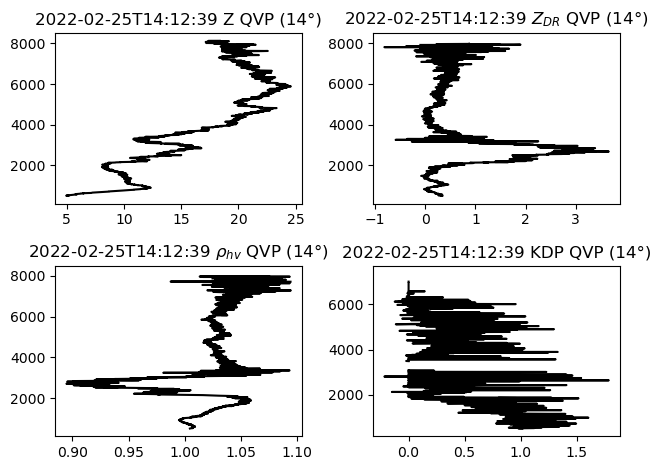

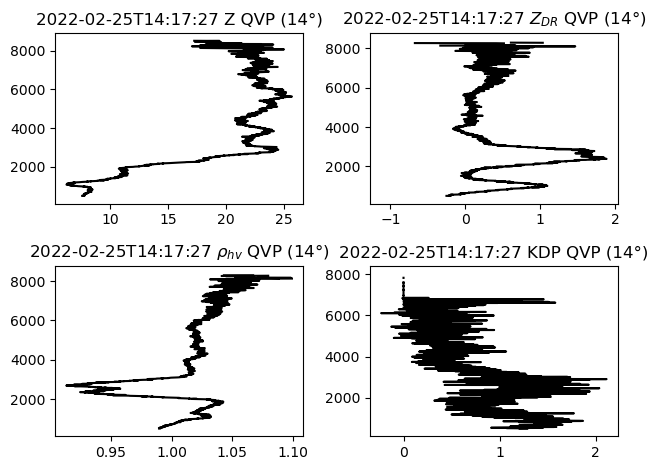

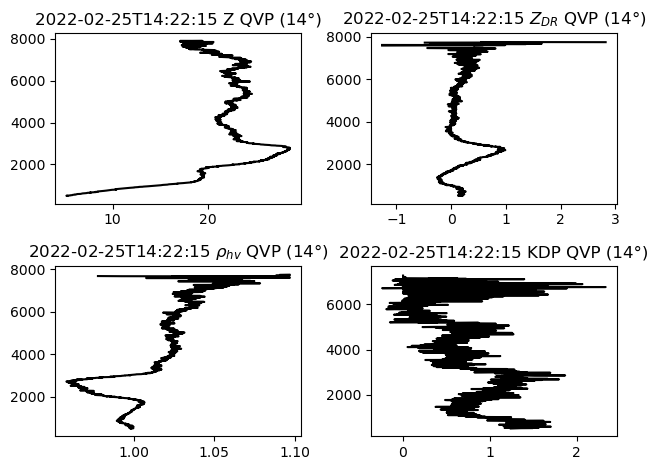

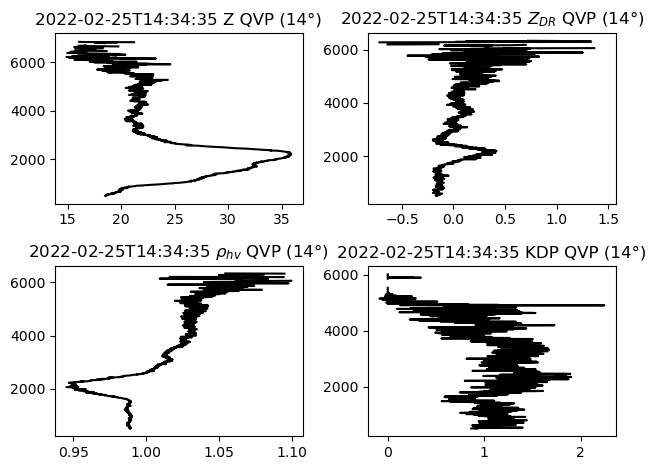

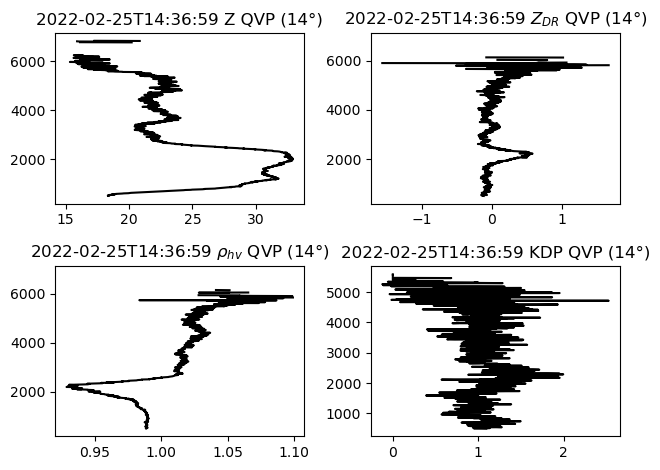

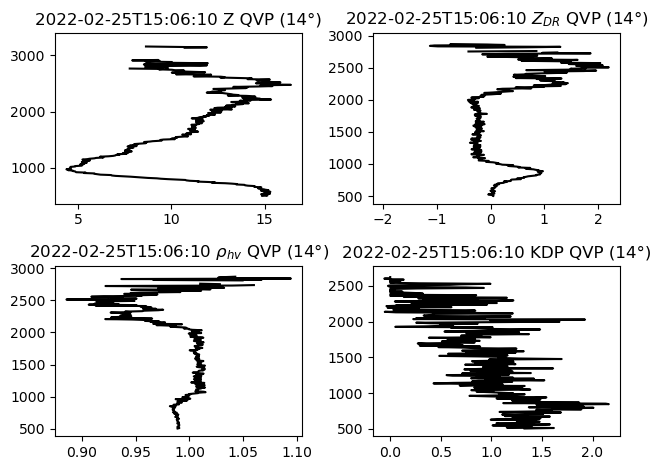

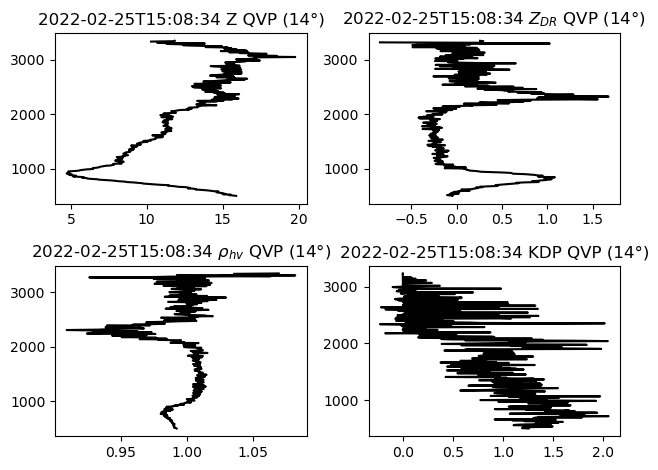

In [175]:
# Fixed time QVPs

for time_start in range(len(times)):
    time = times[time_start]
    
    fig, axis = plt.subplots(2,2)
 

    f_idx = 0
    for ax in axis:
        for a in ax:
            a.plot(QVPs[f_idx][height_start:,time_start:time_start+1], height, color = 'black')
          
            a.set_title(f'{time} {field_names[f_idx]} QVP (14°)')
            f_idx+=1
    plt.tight_layout()
    plt.savefig(f'Figures/{event}/Fixed/QVP/{time}.png')
    plt.show()


# For Albany Event, analyzing spectral reflectivity from MRR every 15 minutes

/var/folders/31/s39c2x6d037_7hyqq4dw3tnh0000gn/T/ipykernel_25279/1186807374.py:8: RuntimeWarning: divide by zero encountered in log10
  10*np.log10(sref[np.where(mrr['time'].data==time)[0][0]]),\
/var/folders/31/s39c2x6d037_7hyqq4dw3tnh0000gn/T/ipykernel_25279/1186807374.py:8: RuntimeWarning: invalid value encountered in log10
  10*np.log10(sref[np.where(mrr['time'].data==time)[0][0]]),\


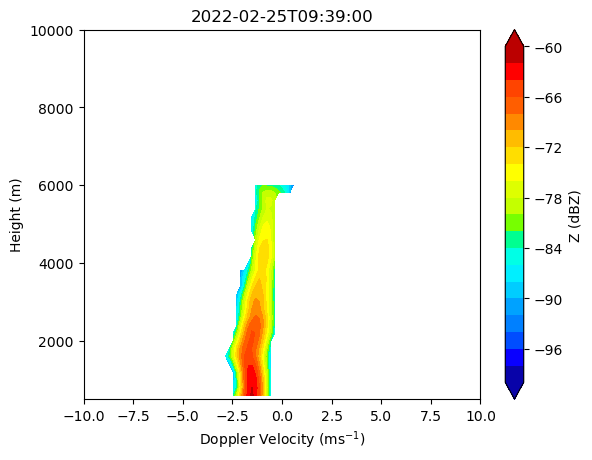

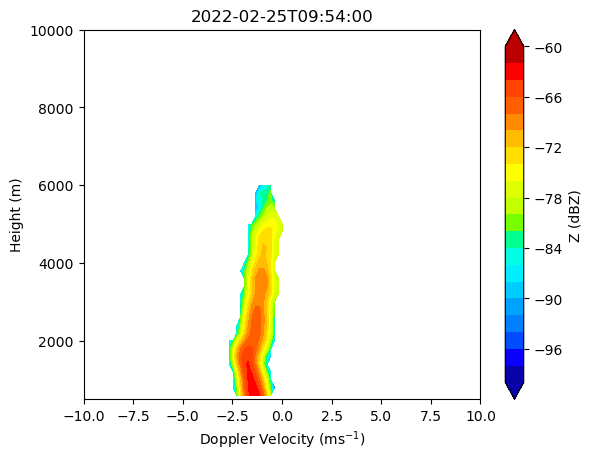

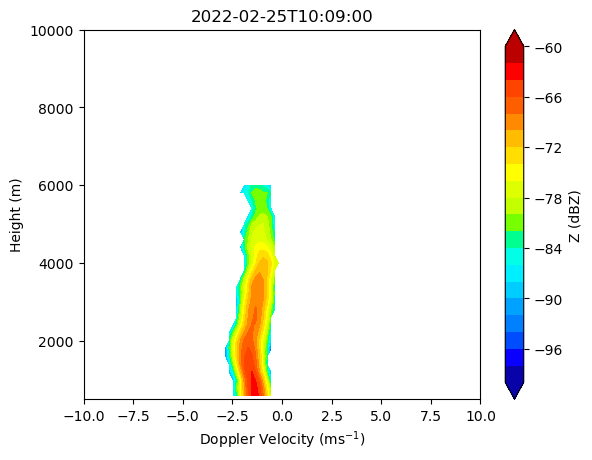

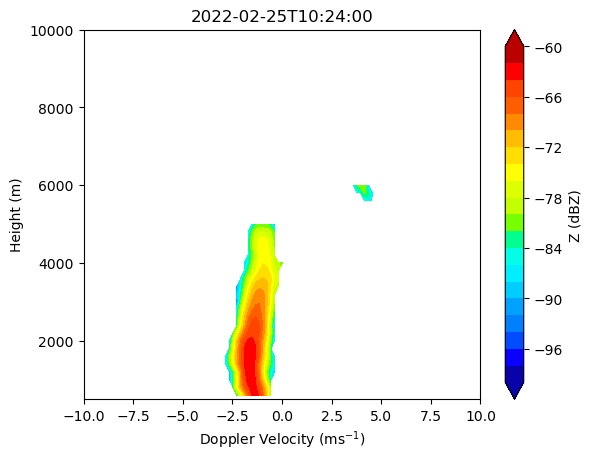

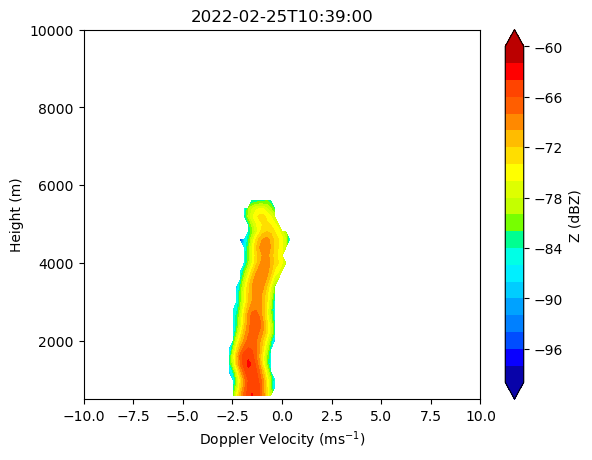

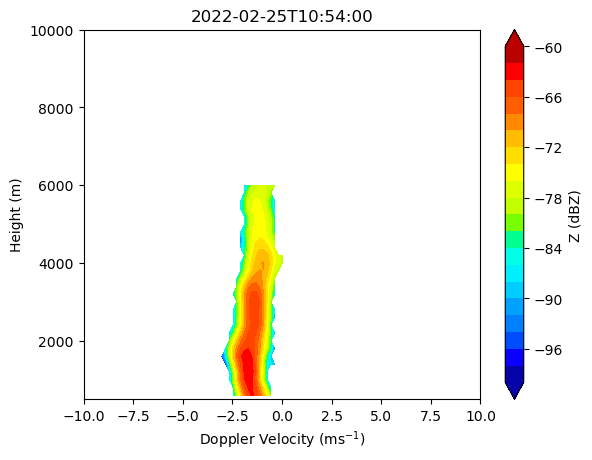

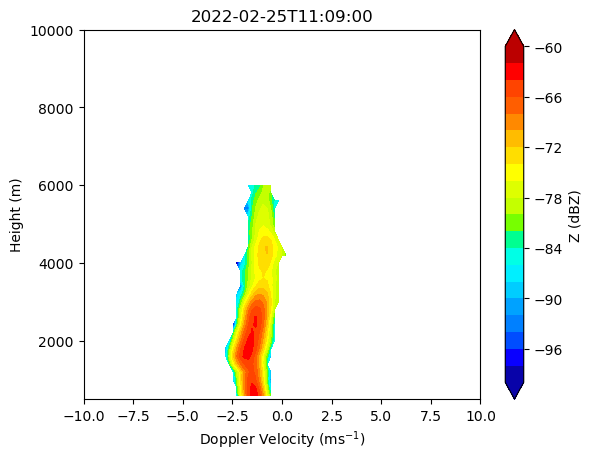

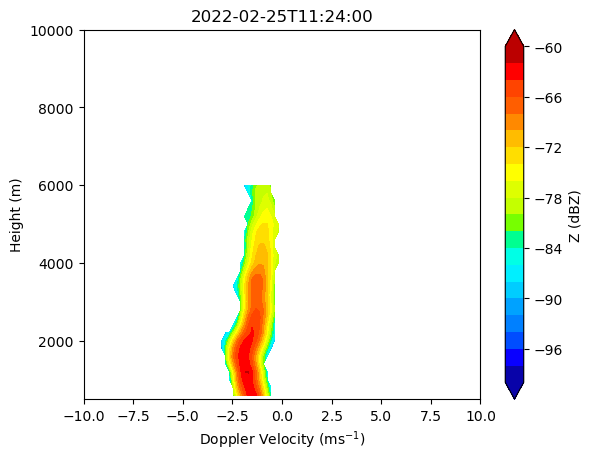

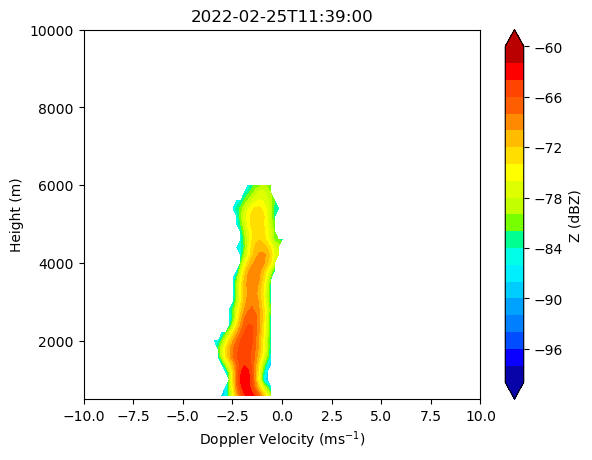

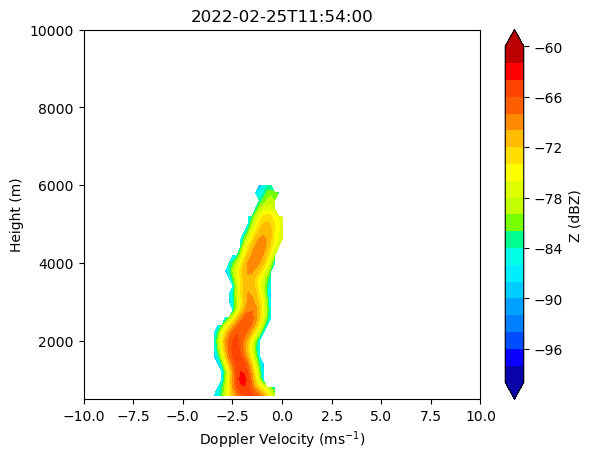

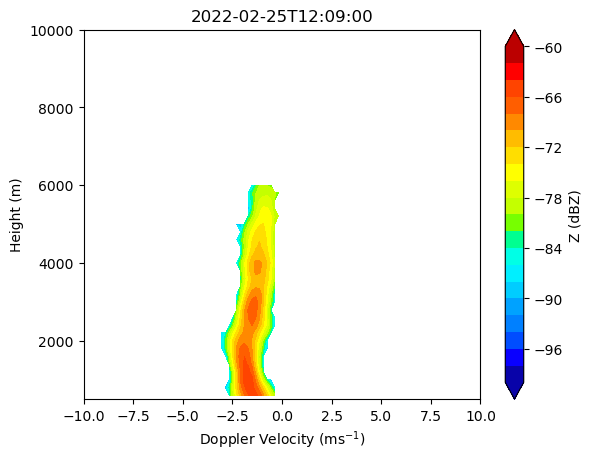

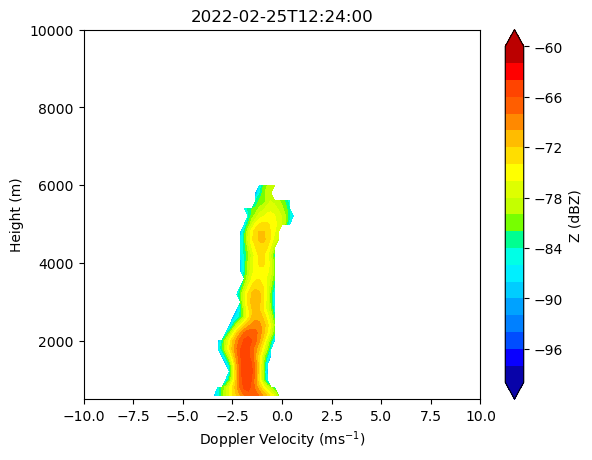

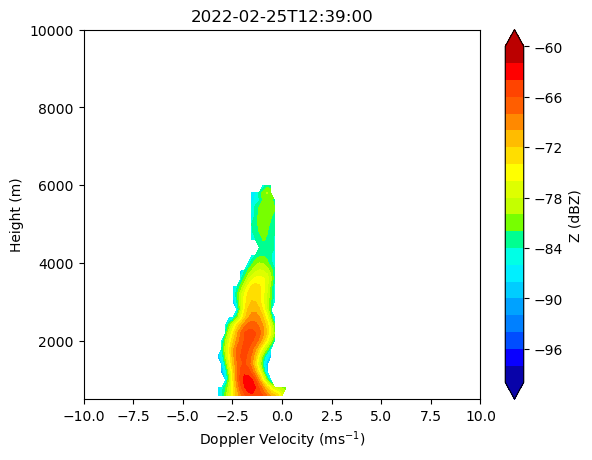

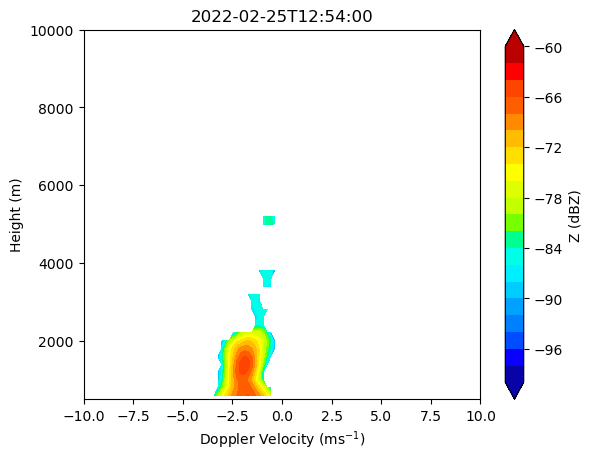

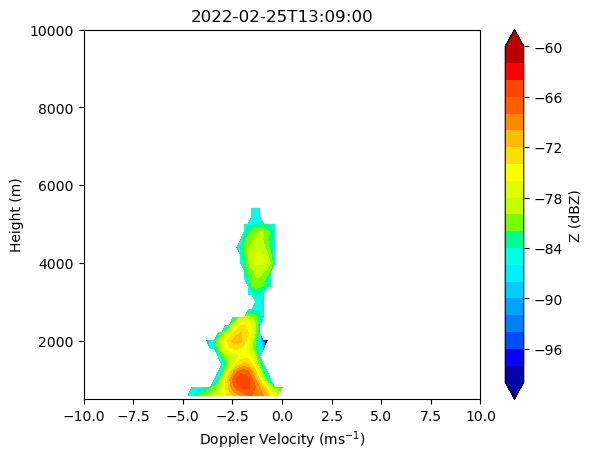

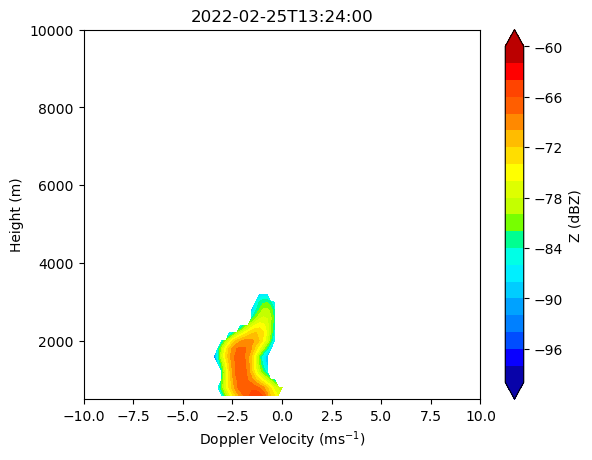

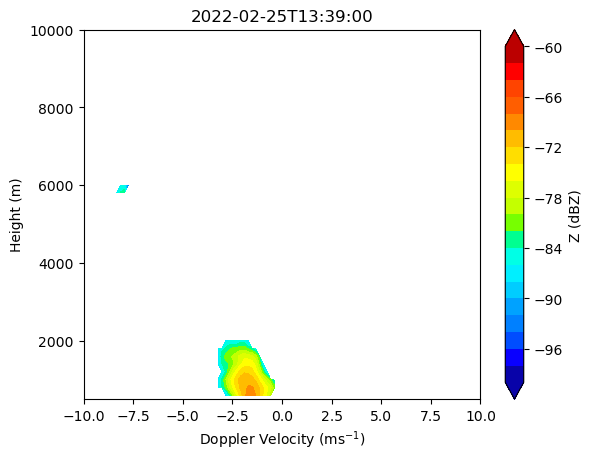

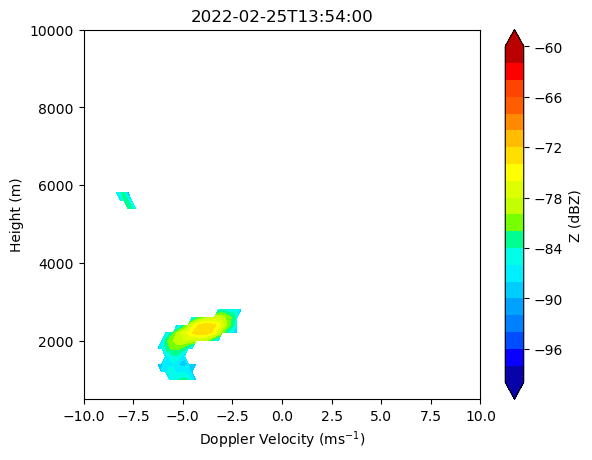

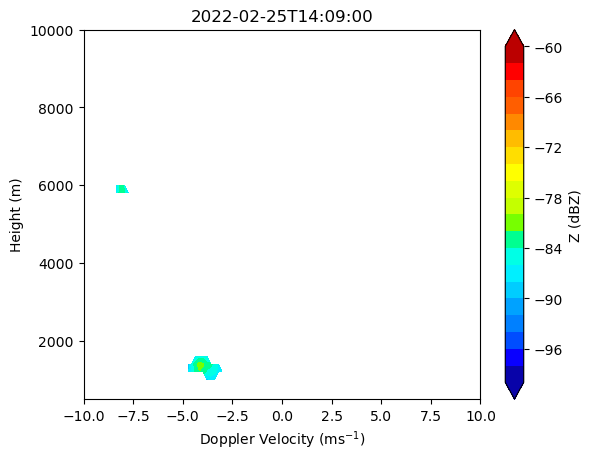

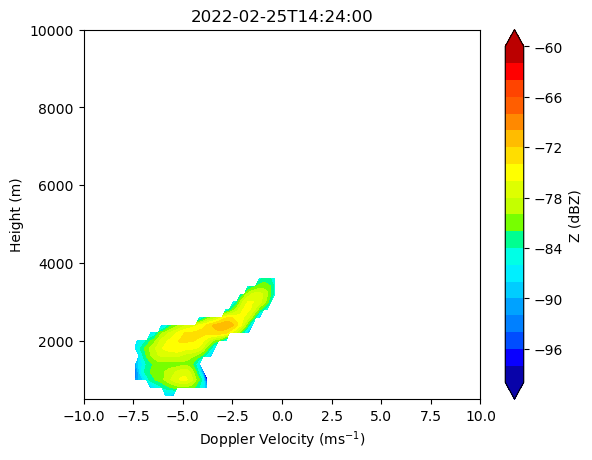

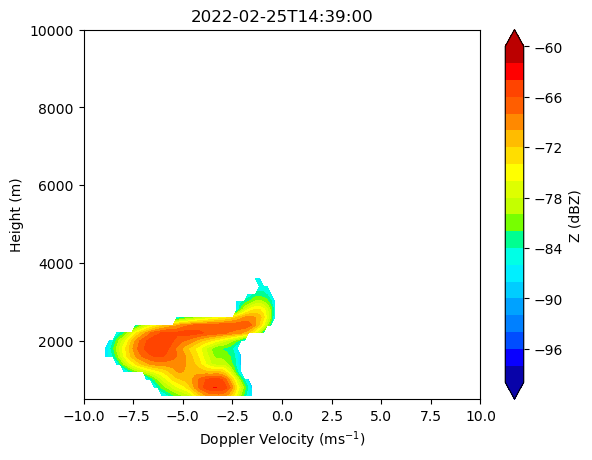

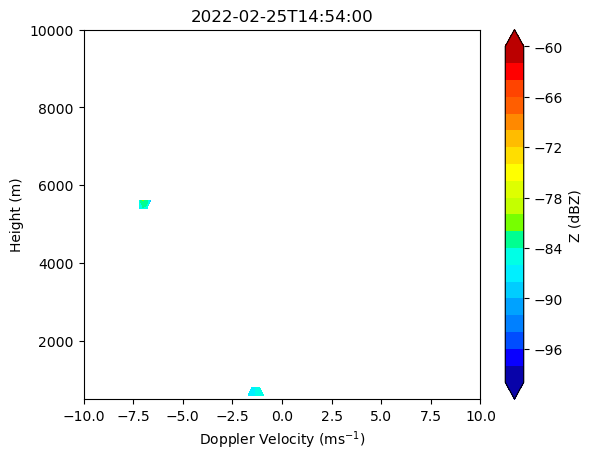

In [176]:
if event == 'Albany':
    mrr = xr.load_dataset('IMPACTS_UALB_mrr2_20220225.nc') 
    sref= np.ma.array(mrr['eta'], mask = mrr['etaMask'])
    for time in np.arange(np.datetime64('2022-02-25T09:39:00'), np.datetime64('2022-02-25T15:08'), \
                         np.timedelta64(15, 'm')):

        fig, axis = plt.subplots()
        cs = axis.contourf(-mrr['velocity'].data, mrr['height'].data[np.where(mrr['time'].data==time)[0][0],:], \
                      10*np.log10(sref[np.where(mrr['time'].data==time)[0][0]]),\
                     levels = np.linspace(-100,-60, 21), colors = colors, extend='both')
        cbar = fig.colorbar(cs)
        cbar.ax.set_ylabel('Z (dBZ)')



        axis.set_ylim([500,10000])
        axis.set_xlim([-10,10])
        axis.set_xlabel('Doppler Velocity ' + r'(ms$^{-1}$)')
        axis.set_ylabel('Height (m)')
        axis.set_title(time)
        plt.savefig(f'Figures/Albany/fixed/Spectral/{time}.png')
        plt.show()


# Radial Velocity RHI Plot 

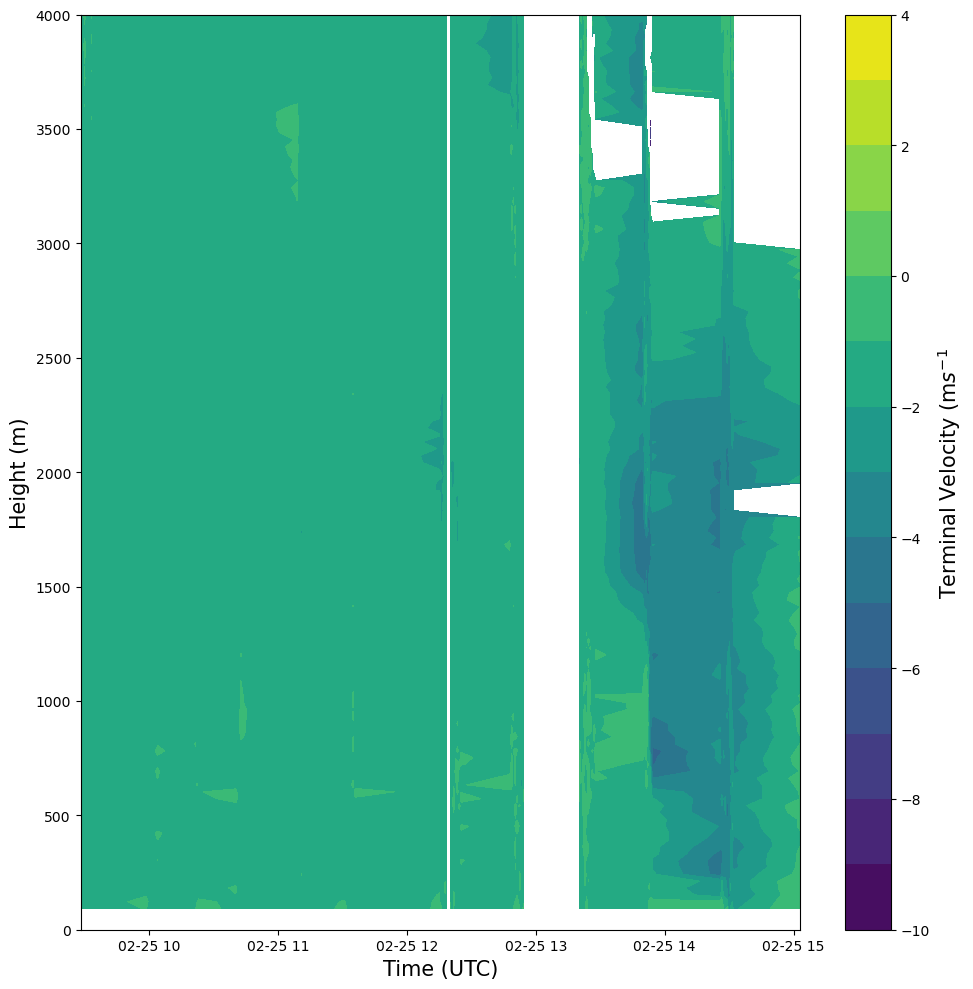

In [182]:
rhi_scans = {'time':[], 'radial_velocity':[]}
secondary_scans = {'time':[], 'radial_velocity':[]}

num_gates = 1240
for data_dir in data_dirs:

    var_files = [os.path.join(data_dir[0],file) for file in data_dir[2]] 
    
    rv_dataset = xr.load_dataset(var_files[np.where([file is not None for file in np.array([re.search('-V.nc', file) for file in var_files])])[0][0]])

    
    if rv_dataset.attrs['ScanType']=='RHI':
        
        if round(rv_dataset['Elevation'].data[-1])==90:
        
            time = numtodate(rv_dataset.attrs['Time'])
            
            if event =='Plymouth':
                if time>np.datetime64('2022-01-29T18:30'):
                    break
            rhi_scans['time'].append(time)

            rv = rv_dataset['Radial_Velocity'][-1, :num_gates].data

            rv = np.ma.array(rv, mask = (rv== rv_dataset.attrs['MissingData']) \
                              | (rv==rv_dataset.attrs['RangeFolded']))


            rhi_scans['radial_velocity'].append(rv)
        else:
            
            time = numtodate(rv_dataset.attrs['Time'])
            
            if event =='Plymouth':
                if time>np.datetime64('2022-01-29T18:30'):
                    break
            secondary_scans['time'].append(time)

            rv = rv_dataset['Radial_Velocity'][-1, :num_gates].data

            rv = np.ma.array(rv, mask = (rv== rv_dataset.attrs['MissingData']) \
                              | (rv==rv_dataset.attrs['RangeFolded']))


            secondary_scans['radial_velocity'].append(rv)
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
cs = ax.contourf(rhi_scans['time'], np.arange(2.5, num_gates*30+1, 30)[3:], \
            np.array(rhi_scans['radial_velocity'])[:,3:].T, levels = np.linspace(-10,4, 15))

cbar = fig.colorbar(cs)
try:
    cbar.ax.set_ylabel('Terminal Velocity' + r" (m$s^{-1}$", fontsize = 15)
except:
    cbar.ax.set_ylabel(field_names[field_idx])
ax.set_ylim(0, 4000)
ax.set_xlabel('Time (UTC)', fontsize = 15)
ax.set_ylabel('Height (m)', fontsize = 15)

plt.tight_layout()
plt.savefig(f'Figures/{event}/series/RHI/RadialVelocity.png')
plt.show()

        